In [144]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import multivariate_normal
import numpy as np
import math

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [145]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [146]:
# functions
def sample_from_task_sequence(t, N=10):
    if (t // (N/2)) % 2 == 0:
        mu = 1
    else:
        mu = -1
    Y = np.random.binomial(1, 0.5)
    X = np.random.normal((-1)**(Y+1)*mu, 0.5)
    return X, t, Y

def compute_cumulative_error(model, t, N, T, num_reps=10):
    preds = []
    gts = []
    model.eval()
    for rep in range(num_reps):
        testdata = np.array([sample_from_task_sequence(s, N) for s in range(t, T)])
        Xt = torch.Tensor(testdata[:, :-1])
        Yt = testdata[:, -1]
        out = model(Xt)
        preds.append(out.detach().argmax(1).numpy())
        gts.append(Yt)
    preds = np.array(preds)
    gts = np.array(gts)
    mean_error = np.mean(preds != gts)
    std_error = np.std(preds != gts)
    return mean_error, std_error

In [178]:
# archiectures 
class AttentionLayer(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim, p=0.1):
        super().__init__()
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, hidden_dim, p),
            nn.ReLU(),
            nn.Linear(hidden_dim, d_model, p),
        )
        self.mha = nn.MultiheadAttention(d_model, num_heads, p)
        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)

    def forward(self, x):
        attn_output, _ = self.mha(x, x, x)
        out1 = self.layernorm1(x + attn_output)
        ff_output = self.feed_forward(out1)
        out2 = self.layernorm2(out1 + ff_output)
        return out2

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, d_model, num_heads, ff_hidden_dim, num_attn_blocks=1, num_classes=2, max_len=5000):
        super().__init__()
        self.input_size = input_size
        self.d_model = d_model
        self.attention_blocks = nn.ModuleList(
            [AttentionLayer(d_model, num_heads, ff_hidden_dim) for _ in range(num_attn_blocks)]
        )
        self.input_embedding = nn.Linear(input_size+1, d_model // 2)
        self.layernorm = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.classifier = nn.Linear(d_model, num_classes)

        # positional encoding
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model//2, 2) * (-math.log(10000.0) / (d_model//2)))
        pe = torch.zeros(1, max_len, d_model//2)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

        # modulo encoding
        position = torch.arange(max_len).unsqueeze(1)
        L = torch.arange(1, d_model//2+1, 1) * 5
        me = torch.fmod(position, L).unsqueeze(0) / L
        self.register_buffer('me', me)

    def position_encoder(self, t):
        pos_enc = torch.cat([self.pe.cpu()[:, t[i].squeeze().long(), :] for i in range(t.size(0))])
        return pos_enc.to(device)

    def modulo_encoder(self, t):
        mod_enc = torch.cat([self.me.cpu()[:, t[i].squeeze().long(), :] for i in range(t.size(0))])
        return mod_enc.to(device)
        
    def forward(self, z):
        x, t, y = torch.split(z, [self.input_size, 1, 1], dim=-1)
        u = torch.cat((x, y), dim=-1)
        u = self.input_embedding(u)

        # t = self.position_encoder(t)
        t = self.modulo_encoder(t)

        # x = self.layernorm(u + t)
        x = torch.cat((u, t), dim=-1)

        for attn_block in self.attention_blocks:
            x = attn_block(x)
        x = torch.select(x, 1, x.shape[1]-1)
        x = self.classifier(x)
        return x

# dataset 
class SequentialDataset(Dataset):
    def __init__(self, N, t, memory=200, seed=1996):
        np.random.seed(seed)
        data = np.array([sample_from_task_sequence(s, N) for s in range(0, t)])
        self.data = torch.from_numpy(data)
        self.memory = memory
        self.t = t

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        r = np.random.randint(0, len(self.data)-2*self.memory) # select the end of the subsequence
        s = np.random.randint(r+self.memory, r+2*self.memory)  # select a 'future' time beyond the subsequence
        z = torch.cat((self.data[r:r+self.memory], self.data[s:s+1]))
        y = z[-1, -1].clone()
        z[-1, -1] = 0.5
        return z, y

In [179]:
# distribution params
t = 1000 # length of the training sequence
N = 20   # period of switching tasks (task switches every N/2 time steps)

# training params
batch_size = 32 
num_epochs = 1000
lr = 0.01
verbose=True

# evaluation params
T = 1200 # future time horizon
num_reps = 10

In [180]:
dataset = SequentialDataset(N=20, t=1000)
trainloader = DataLoader(dataset, batch_size=batch_size)

model = TransformerClassifier(
    input_size=1,
    d_model=64, 
    num_heads=4,
    ff_hidden_dim=128,
    num_attn_blocks=2,
    num_classes=2
)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    losses = 0.0
    train_acc = 0.0
    for z, y in trainloader:
        z = z.float().to(device)
        y = y.long().to(device)

        out = model(z)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        losses += loss.item()
        optimizer.step()
        train_acc += (out.argmax(1) == y).cpu().numpy().mean()
    scheduler.step()
    if verbose and epoch % 100 == 0:
        print("Training loss at epoch {} : {:4f}, Training Acc : {:4f}".format(epoch+1, losses/batch_size, train_acc/batch_size))

Training loss at epoch 1 : 0.718825, Training Acc : 0.508789
Training loss at epoch 101 : 0.010930, Training Acc : 0.999023
Training loss at epoch 201 : 0.003661, Training Acc : 0.999023
Training loss at epoch 301 : 0.001667, Training Acc : 1.000000
Training loss at epoch 401 : 0.001301, Training Acc : 1.000000
Training loss at epoch 501 : 0.000640, Training Acc : 1.000000
Training loss at epoch 601 : 0.000516, Training Acc : 1.000000
Training loss at epoch 701 : 0.000274, Training Acc : 1.000000
Training loss at epoch 801 : 0.000195, Training Acc : 1.000000
Training loss at epoch 901 : 0.000208, Training Acc : 1.000000


In [181]:
t = 1000
T = 2000

preds = []
truths = []
model.eval()
for rep in range(num_reps):
    testdata = np.array([sample_from_task_sequence(s, N) for s in range(t, T)])
    testdata = torch.from_numpy(testdata)
    pred_rep = []
    truth_rep = []
    for s in range(len(testdata)):
        z = torch.cat((dataset.data[-200:], testdata[s:s+1]))
        y = z[-1, -1].clone()
        z[-1, -1] = 0.5
        z = z.view(1, z.shape[0], z.shape[1])
        y = y.view(1)
        z = z.float().to(device)
        y = y.long().to(device)
        out = model(z)
        pred_rep.append(out.detach().cpu().argmax(1).numpy())
        truth_rep.append(y.detach().cpu().numpy())
    preds.append(pred_rep)
    truths.append(truth_rep)
preds = np.array(preds)
truths = np.array(truths)

In [182]:
mean_error = np.mean(preds != truths, axis=0).squeeze()
std_error = np.std(preds != truths, axis=0).squeeze()
ci = std_error * 1.96/np.sqrt(num_reps).squeeze()

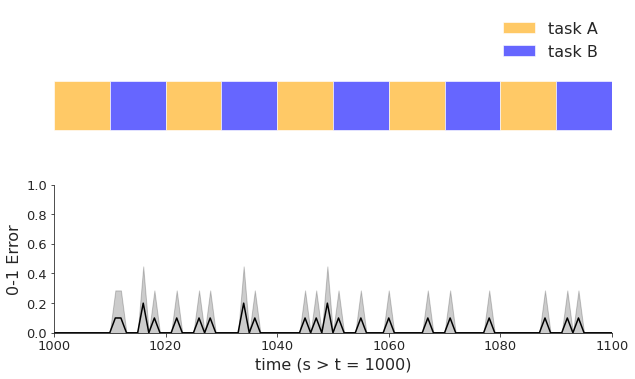

In [183]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
ax = axes[0]
end = 100+1
future = np.arange(t, t+end, 1)
errors = mean_error[:end]
c = ci[:end]
xlocs = np.arange(t, t+end, N/2)
for i, x in enumerate(xlocs):
    if i % 2 == 0:
        ax.add_artist(Rectangle((x, 0), N/2, 2, fc='orange', alpha=0.6))
    else:
        ax.add_artist(Rectangle((x, 0), N/2, 2, fc='b', alpha=0.6))
ax.set_ylim([-1, 5])
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
ax.axis('off')

sns.set_style("white")
sns.set_style("ticks")

ax = axes[1]
ax.plot(future, errors, c='k')
ax.fill_between(future, errors-c, errors+c, alpha=0.2, color='k')
ax.set_ylabel("0-1 Error", fontsize=16)
ax.set_xlabel("time (s > t = {})".format(t), fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.set_ylim([0, 1])
plt.show()



Text(0.5, 0, 'time')

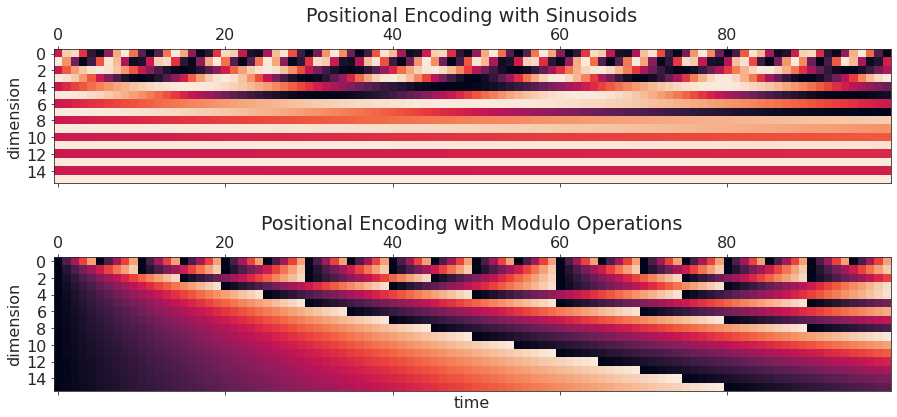

In [119]:
pe = model.pe.detach().cpu().numpy().squeeze()
me = model.me.detach().cpu().numpy().squeeze()

fig, ax = plt.subplots(2, 1, figsize=(15, 7))
ax[0].matshow(pe[:100].T)
ax[0].set_title("Positional Encoding with Sinusoids")
ax[0].set_ylabel("dimension")
ax[1].matshow(me[:100].T)
ax[1].set_title("Positional Encoding with Modulo Operations")
ax[1].set_ylabel("dimension")
ax[1].set_xlabel("time")


### time vs. cumulative risk over the future plot

In [11]:
N = 10
t_list = [100, 500, 1000, 1500, 2000]
T = 5000
num_epochs = 6000
num_reps = 100

data = np.array([sample_from_task_sequence(s, N) for s in range(0, t_list[-1])])

In [ ]:
cumulative_error = []
std_cumulative_error = []
for t in t_list:
    print(t)
    data_t = data[:t]
    X = data_t[:, :-1]
    Y = data_t[:, -1]
    trainloader = get_dataloader(X, Y)
    model = net2(d=1, h=50, num_periods=20, num_hidden=3, num_classes=2)
    model.to(device)
    model = train(model, trainloader, num_epochs, verbose=False)
    mean_err, std_err = compute_cumulative_error(model, t, N, T, num_reps)
    cumulative_error.append(mean_err)
    std_cumulative_error.append(std_err)
cumulative_error = np.array(cumulative_error)
std_cumulative_error = np.array(std_cumulative_error)
ci = std_cumulative_error * 1.96 / np.sqrt(num_reps)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(t_list, cumulative_error, 'o-')
ax.fill_between(t_list, cumulative_error-ci, cumulative_error+ci, alpha=0.2)
ax.set_xlabel('t')
ax.set_ylabel(r'cumulative risk until $T = {}$'.format(T))
plt.show()